In [1]:
import os
from sys import exit,argv
import humanfriendly as hf
import time
#import random
from datetime import datetime
from tqdm import tqdm
import numpy as np
import pandas as pd
from tabulate import tabulate
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning':0})
#from matplotlib.colors import LinearSegmentedColormap
from matplotlib.backends.backend_pdf import PdfPages
import os
from colorama import Fore,Back,Style
from colorama import init
init(autoreset=True)
import warnings
warnings.filterwarnings("ignore")

In [2]:
def GoNoGoUserPrompt():
    while True:
        print('\t\t',Back.RED+'INPUT:',end='')
        value = input(f" Happy to continue(Y|y|N|n): ")
        if value.lower() == "y":
            break
        elif value.lower() == "n":
            exit("No problem exiting.")
        else:
            print ("\tERROR!!! We are only accepting Y|y for yes or N|n for No.")

In [3]:
def GetFiles(path):
    suffix = ".csv"
    filenames = os.listdir(path)
    csvfiles = [filename for filename in filenames if filename.endswith(suffix)]
    if len (csvfiles) == 0:
        exit(f"There were no '.csv' files in the the given path ({path}).")
    elif len (csvfiles) > 0:
        while True:
            print('\n ',Back.GREEN+'INPUT:',end='')
            value = input(f" Found {len(csvfiles)} files in the directory, happy to continue(Y|y|N|n): ")
            if value.lower() == "y":
                break
            elif value.lower() == "n":
                exit("No problem exiting.")
            else:
                print ("\tERROR!!! We are only accepting Y|y for yes or N|n for No.")
    return csvfiles

In [4]:
def CreatePDF(pdffilename,comment):
    p = PdfPages(pdffilename)
    fig_nums = plt.get_fignums()
    figs = [plt.figure(n) for n in fig_nums]
    for fig in tqdm(figs, desc=f" ## Converting plots to PDFs: {comment}:", position=1,leave=False):
        fig.savefig(p, format='pdf')
    p.close()

In [5]:
def Within30Minutes(Date,CurrentEpocSeconds):
    Year = pd.to_datetime(Date).year
    Month = pd.to_datetime(Date).month
    Day = pd.to_datetime(Date).day
    Hour = pd.to_datetime(Date).hour
    NearestHour = datetime(Year,Month,Day,Hour,0,0)
    EpochTime = datetime(1970,1,1)
    NearestHourADOS = (NearestHour-EpochTime).total_seconds()
    #
    Delta = (CurrentEpocSeconds - NearestHourADOS)
    if Delta > 1800:
        return int(Delta-1800)
    else:
        return int(Delta)

In [6]:
SeletedYear = 2023 #2019 #2022
tic_0 = time.time()

In [7]:
path = f'./0.DataSource/Frequency/Data/{SeletedYear}'
files = tqdm(GetFiles(path)[0:])
list_ = []
for name in files:
    files.set_description(f" -Ingesting Data ({name})",refresh=True)
    filename = f"{path}/{name}"
    df_temp = pd.read_csv(filename,skip_blank_lines=True,sep=',')
    list_.append(df_temp)
MainDF = pd.concat(list_)
print(f" -Reading files complete, {MainDF.shape[0]} datapoints - {hf.format_timespan(time.time()-tic_0)}.")
print(f" -Converting to UTC time - {hf.format_timespan(time.time()-tic_0)}.")
MainDF['dtm'] = pd.to_datetime(MainDF['dtm'])
MainDF = MainDF.rename(columns={'dtm':'DateTime_UTC','f':'Frequency(Hz)'})


  INPUT:

 Found 12 files in the directory, happy to continue(Y|y|N|n):  y


 -Ingesting Data (fnew-2023-9.csv): 100%|██████████| 12/12 [00:17<00:00,  1.50s/it]


 -Reading files complete, 31536000 datapoints - 20.77 seconds.
 -Converting to UTC time - 20.77 seconds.


In [8]:
print(f" -Converting UTC time to ADOS time - {hf.format_timespan(time.time()-tic_0)}.")
MainDF['EpocSeconds'] = MainDF['DateTime_UTC'].astype('int64')//1e9
MainDF['EpocSeconds'] = MainDF['EpocSeconds'].astype('int64')                              # Speeds up computation
print(f" -Sorting ADOS time - {hf.format_timespan(time.time()-tic_0)}.")
MainDF.sort_values(by=['EpocSeconds'],inplace=True)
MainDF = MainDF.reset_index(drop=True)
MainDF['FreqDiff'] = MainDF["Frequency(Hz)"].diff(-1)
print(f" -Vectorizing parameters - this will take some time!! - {hf.format_timespan(time.time()-tic_0)}.")
MainDF['Within30Minutes'] = np.vectorize(Within30Minutes)(MainDF['DateTime_UTC'],MainDF['EpocSeconds'])
print(f" -Vectorizing complete - {hf.format_timespan(time.time()-tic_0)}.")
MainDF['Month'] = MainDF['DateTime_UTC'].dt.month
MainDF['ABS_FreqDiff'] = MainDF['FreqDiff']

 -Converting UTC time to ADOS time - 38.01 seconds.
 -Sorting ADOS time - 38.97 seconds.
 -Vectorizing parameters - this will take some time!! - 40.66 seconds.
 -Vectorizing complete - 4 minutes and 26.13 seconds.


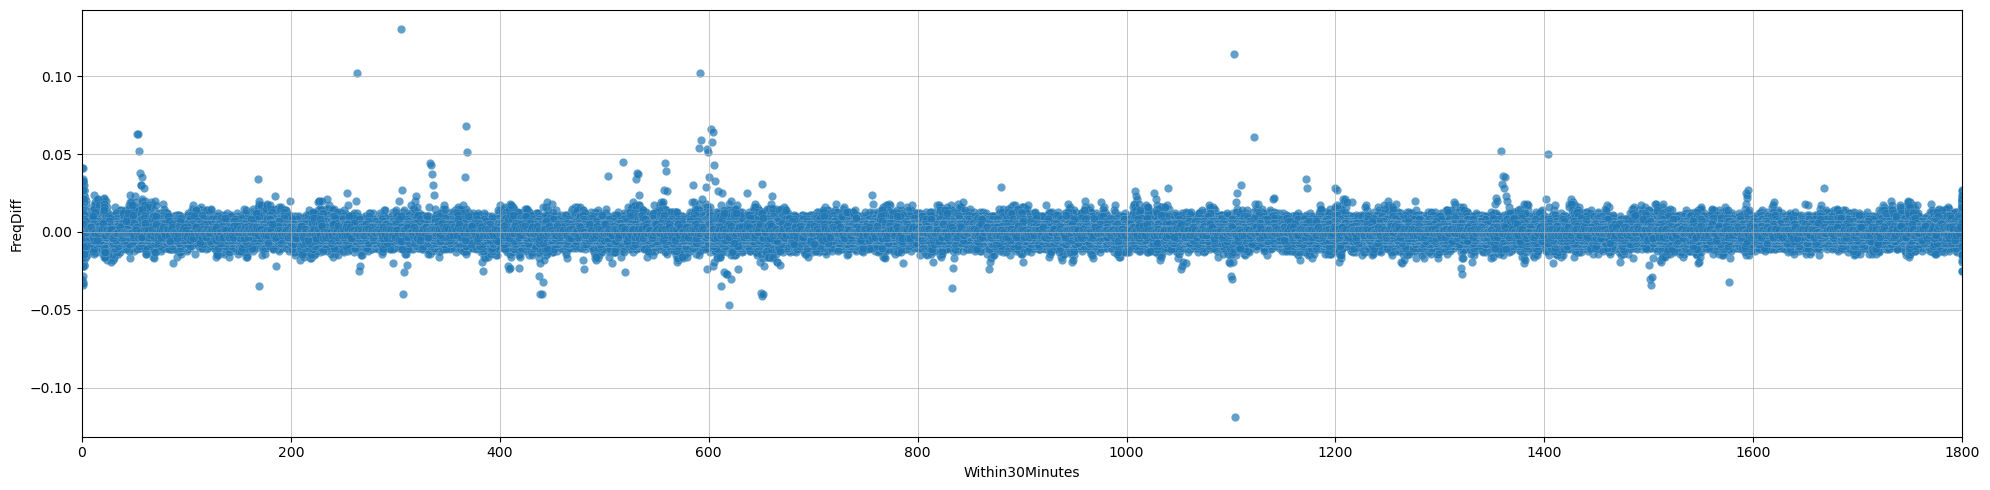

In [28]:
MainDF1 = MainDF.loc[MainDF['Month'] == 12]
plt.figure(figsize=(20,5))
sns.scatterplot(data=MainDF1,x='Within30Minutes',y='FreqDiff',linewidth=0.1,alpha=0.7)
plt.xlim(0,1800)#;plt.ylim(0,)
plt.grid(which='both',linewidth = 0.5)
plt.tight_layout()

SyntaxError: expected 'else' after 'if' expression (3928001974.py, line 2)

In [10]:
MainDF.loc[0,'DateTime_UTC']

Timestamp('2023-01-01 00:00:00')

In [11]:
print(f"######### COMPLETED ######## - {hf.format_timespan(time.time()-tic_0)}.")

######### COMPLETED ######## - 4 minutes and 26.27 seconds.
